In [2]:
import iris
import iris.plot as iplt
import numpy as np
from iris.coords import DimCoord
from iris.coord_systems import TransverseMercator,GeogCS
from iris.cube import Cube
from cf_units import Unit
import cf_units
import os
import glob
from pyproj import Proj, transform
import sys
import warnings
import multiprocessing as mp
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

ems_hourly = ['01', '04', '06', '07', '08', '09', '10', '11', '12', '13', '15']
ems_30mins = ['bc005', 'bc006', 'bc007', 'bc009', 'bc010', 'bc011', 'bc013',  'bc015',  'bc016', 'bc017', 'bc018', 'bc012']
yrs_range = '1980_2001'

In [92]:
##########################################################################################
#########################################################################################
# Define variables and set up environment
##########################################################################################
##########################################################################################
root_fp = "/nfs/a319/gy17m2a/"
os.chdir(root_fp)

# Create path to files containing functions
sys.path.insert(0, root_fp + 'PhD/Scripts/DataProcessing/Regridding')
from Regridding_functions import *
# Create path to files containing functions
sys.path.insert(0, root_fp + 'Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

gb_gdf = create_gb_outline({'init' :'epsg:3857'})

# Load UKCP18 12km model data to use in regriddding
file_model_12km=f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/12km/01/{yrs_range}/pr_rcp85_land-rcm_uk_12km_01_day_19801201-19901130.nc'
cube_12km=iris.load_cube(file_model_12km)

file_model_2_2km ='/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km/01/1980_2001/pr_rcp85_land-cpm_uk_2.2km_01_1hr_19910601-19910630.nc'
cube_2km =iris.load_cube(file_model_2_2km)

file_model_2_2km_bng ='/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km_bng/01/1980_2001/bng_pr_rcp85_land-cpm_uk_2.2km_01_1hr_19910601-19910630.nc'
cube_2km_bng =iris.load_cube(file_model_2_2km_bng)

# remove ensemble member dimension
cube_2km = cube_2km[0,:,:,:]
cube_12km = cube_12km[0,:,:,:]

In [ ]:
# this is the crs that we want to transform to
source_crs_2km = ccrs.RotatedGeodetic(pole_latitude=37.5,
                                        pole_longitude=177.5,
                                        central_rotated_longitude=0)

In [ ]:
##################################################################
# This is a square area surrounding Leeds
leeds_at_centre_gdf = create_leeds_at_centre_outline({'init' :'epsg:3857'})
cube_12km_trimmed_to_leeds =  trim_to_bbox_of_region_obs(cube_12km, leeds_at_centre_gdf, 'projection_y_coordinate',
                                                        "projection_x_coordinate")

In [ ]:
yrs_range = '1980_2001'
# ems_hourly = ['04', '06', '07', '08', '09', '10', ]

### Trim so the same size

In [ ]:
# cube_2km = trim_to_bbox_of_region_regriddedobs(cube_2km, gb_gdf)
# cube_12km = trim_to_bbox_of_region_obs(cube_12km, gb_gdf)

# iplt.contourf(cube_12km[1,:,:])
# plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

## Transform cube 2.2km to WGS84 and then to 12km

In [29]:
for em in ['01', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '15']:
    print(em)
    os.chdir(f"/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km/{em}/{yrs_range}/")
    output_fp_bng = f"/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km_bng/{em}/{yrs_range}/"
    output_fp_bng_regridded = f"/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km_bng_regridded_12km/{em}/AreaWeighted/{yrs_range}/"
    if not os.path.isdir(output_fp_bng):
        os.makedirs(output_fp_bng)
    if not os.path.isdir(output_fp_bng_regridded):
        os.makedirs(output_fp_bng_regridded)        
    for filename in np.sort(glob.glob("*")):     
            if filename[47:49] in ['06', '07', '08']:
                if os.path.isfile(output_fp_bng +  f"bng_{filename}"):
                    print("already exist")                    
                else:
                    print(filename)
                    cube_2km = iris.load(filename)[0]
                    cube_2km = cube_2km[0,:,:,:]
                    # transform to BNG
                    cube_2km_bng= convert_rotatedpol_to_bng (cube_2km)
                    # regrid to 12km
                    cube_2km_regridded_12km_bng = cube_2km_bng.regrid(cube_12km, iris.analysis.AreaWeighted()) 
                    # Save 
                    iris.save(cube_2km_bng, output_fp_bng +  f"bng_{filename}")
                    iris.save(cube_2km_regridded_12km_bng, output_fp_bng_regridded +  f"bng_rg_{filename}")     

01
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
04
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist


already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist


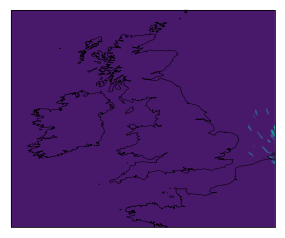

In [21]:
iplt.contourf(cube_2km_wgs84[100,:,:])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

## Transform cube 2.2km to BNG and then to 12km

In [ ]:
for em in ['01']:
    print(em)
    os.chdir(f"/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km/{em}/{yrs_range}/")
    output_fp_wgs84 = f"/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km_wgs84/{em}/{yrs_range}/"
    output_fp_regridded = f"/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km_regridded_12km/{em}/AreaWeighted/{yrs_range}/"
    if not os.path.isdir(output_fp_wgs84):
        os.makedirs(output_fp_wgs84)
    if not os.path.isdir(output_fp_regridded):
        os.makedirs(output_fp_regridded)        
    for filename in np.sort(glob.glob("*")):     
            if filename[47:49] in ['06', '07', '08']:
                if os.path.isfile(output_fp_wgs84 +  f"wgs84_{filename}"):
                    print("already exist")                    
                else:
                    print(filename)
                    cube_2km = iris.load(filename)[0]
                    cube_2km = cube_2km[0,:,:,:]
                    # transform to wgs84
                    cube_2km_wgs84 = convert_to_wgs84 (source_crs_2km, cube_2km, "grid_longitude", "grid_latitude")
                    # regrid to 12km
                    cube_2km_regridded_12km_wgs84 = cube_2km_wgs84.regrid(cube_12km_wgs84, iris.analysis.AreaWeighted()) 
                    # Save 
                    iris.save(cube_2km_wgs84, output_fp_wgs84 +  f"wgs84_{filename}")
                    iris.save(cube_2km_regridded_12km_wgs84, output_fp_regridded +  f"wgs84_rg_{filename}")     

## Regrid 30 mins UKCP18 data to 12km - DONE
For this need to use version of the regridding cube which is trimmed to the leeds-at-centre region, as the 30 mins data is already clipped to this extent

In [12]:
ems_30mins =  ['bc005',  'bc006',  'bc007', 'bc009',  'bc010', 
       'bc011', 'bc013',  'bc015',  'bc016',  'bc017', 'bc018', 'bc012']

In [14]:
for em in ems_30mins:
    print(em)
    os.chdir(f"/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/2.2km/{em}/2002_2020/")
    output_fp = f"/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/2.2km_regridded_12km/{em}/NearestNeighbour/2002_2020/"
    if not os.path.isdir(output_fp):
        os.makedirs(output_fp)
    for filename in np.sort(glob.glob("*")):   
        print(filename)
        if not os.path.isfile(output_fp +  f"rg_{filename}"):
            print("creating")
            # print(filename)
            cube = iris.load(filename)[0]
            # Linear interpolation
            #reg_cube_lin =cube.regrid(cube_model,iris.analysis.Linear())      
            # Nearest neighbour
            try:
                reg_cube_nn =cube.regrid(cube_12km_trimmed_to_leeds,iris.analysis.Nearest())   
            except:
                print("Didnt work")
                pass
            # print(reg_cube_nn.shape)
            # Save 
            iris.save(reg_cube_nn, output_fp +  f"rg_{filename}") 
        else:
            print("already exists")

bc005
bc005a.pr200006.nc
already exists
bc005a.pr200007.nc
already exists
bc005a.pr200008.nc
already exists
bc005a.pr200106.nc
already exists
bc005a.pr200107.nc
already exists
bc005a.pr200108.nc
already exists
bc005a.pr200206.nc
already exists
bc005a.pr200207.nc
already exists
bc005a.pr200208.nc
already exists
bc005a.pr200306.nc
already exists
bc005a.pr200307.nc
already exists
bc005a.pr200308.nc
already exists
bc005a.pr200406.nc
already exists
bc005a.pr200407.nc
already exists
bc005a.pr200408.nc
already exists
bc005a.pr200506.nc
already exists
bc005a.pr200507.nc
already exists
bc005a.pr200508.nc
already exists
bc005a.pr200606.nc
already exists
bc005a.pr200607.nc
already exists
bc005a.pr200608.nc
already exists
bc005a.pr200706.nc
already exists
bc005a.pr200707.nc
already exists
bc005a.pr200708.nc
already exists
bc005a.pr200806.nc
already exists
bc005a.pr200807.nc
already exists
bc005a.pr200808.nc
already exists
bc005a.pr200906.nc
already exists
bc005a.pr200907.nc
already exists
bc005a.p

already exists
bc010a.pr200708.nc
already exists
bc010a.pr200806.nc
already exists
bc010a.pr200807.nc
already exists
bc010a.pr200808.nc
already exists
bc010a.pr200906.nc
already exists
bc010a.pr200907.nc
already exists
bc010a.pr200908.nc
already exists
bc010a.pr201006.nc
already exists
bc010a.pr201007.nc
already exists
bc010a.pr201008.nc
already exists
bc010a.pr201106.nc
already exists
bc010a.pr201107.nc
already exists
bc010a.pr201108.nc
already exists
bc010a.pr201206.nc
already exists
bc010a.pr201207.nc
already exists
bc010a.pr201208.nc
already exists
bc010a.pr201306.nc
already exists
bc010a.pr201307.nc
already exists
bc010a.pr201308.nc
already exists
bc010a.pr201406.nc
already exists
bc010a.pr201407.nc
already exists
bc010a.pr201408.nc
already exists
bc010a.pr201506.nc
already exists
bc010a.pr201507.nc
already exists
bc010a.pr201508.nc
already exists
bc010a.pr201606.nc
already exists
bc010a.pr201607.nc
already exists
bc010a.pr201608.nc
already exists
bc010a.pr201706.nc
already exists

already exists
bc016a.pr201407.nc
already exists
bc016a.pr201408.nc
already exists
bc016a.pr201506.nc
already exists
bc016a.pr201507.nc
already exists
bc016a.pr201508.nc
already exists
bc016a.pr201606.nc
already exists
bc016a.pr201607.nc
already exists
bc016a.pr201608.nc
already exists
bc016a.pr201706.nc
already exists
bc016a.pr201707.nc
already exists
bc016a.pr201708.nc
already exists
bc016a.pr201806.nc
already exists
bc016a.pr201807.nc
already exists
bc016a.pr201808.nc
already exists
bc016a.pr201906.nc
already exists
bc016a.pr201907.nc
already exists
bc016a.pr201908.nc
already exists
bc016a.pr202006.nc
already exists
bc016a.pr202007.nc
already exists
bc016a.pr202008.nc
already exists
bc017
bc017a.pr200006.nc
already exists
bc017a.pr200007.nc
already exists
bc017a.pr200008.nc
already exists
bc017a.pr200106.nc
already exists
bc017a.pr200107.nc
already exists
bc017a.pr200108.nc
already exists
bc017a.pr200206.nc
already exists
bc017a.pr200207.nc
already exists
bc017a.pr200208.nc
already 

## Regrid NIMROD - DONE

In [5]:
for year in range(2012,2013):
    print(year)
    # Change directory to be for correct year
    os.chdir(f"/nfs/a319/gy17m2a/PhD/datadir/NIMROD/30mins/OriginalFormat_1km/{year}")
    # Define filepaths to save files to
    output_dir_12km = f"/nfs/a319/gy17m2a/PhD/datadir/NIMROD/30mins/NIMROD_regridded_12km/NearestNeighbour/{year}/"
    output_dir_2_2km = f"/nfs/a319/gy17m2a/PhD/datadir/NIMROD/30mins/NIMROD_regridded_2.2km/NearestNeighbour/{year}/"
    # Create these directories if they don't exist already
    if not os.path.isdir(output_dir_12km):
        os.makedirs(output_dir_12km)
    if not os.path.isdir(output_dir_2_2km):
        os.makedirs(output_dir_2_2km)
    # Loop through all the diles in the 1km folder    
    for filename in sorted(glob.glob("*")):
        if filename != 'metoffice-c-band-rain-radar_uk_20090728_30mins.nc':
            print(filename)
            # Create version of filename specifying it is regridded
            filename_to_save_to = f"rg_{filename}"

            # Check if this regridded file exists, and if not create it
            # Don't want to load the cube twice unnecessarily, so if we load it for 12km, then make a flag to tell us it's
            # already loaded and then use this for 2.2km

            # 12km regridding
            if os.path.isfile(output_dir_12km + filename_to_save_to):
                print("File already exists")
            if not os.path.isfile(output_dir_12km + filename_to_save_to):
                print('Making file 12km')
                cube = iris.load(filename)[0]
                loaded_cube=True
                # Nearest neighbour
                reg_cube_nn =cube.regrid(cube_12km,iris.analysis.Nearest())    
                # Save 
                iris.save(reg_cube_nn, output_dir_12km + filename_to_save_to)

            # 2.2km regridding
            if os.path.isfile(output_dir_2_2km + filename_to_save_to):
                print("File already exists")
            if not os.path.isfile(output_dir_2_2km + filename_to_save_to):
                print('Making 2.2km file')
                if loaded_cube == False:
                    cube = iris.load(filename)[0]
                # Nearest neighbour
                reg_cube_nn =cube.regrid(cube_model_2_2km,iris.analysis.Nearest())    
                print("Regridded")
                # Save 
                iris.save(reg_cube_nn, output_dir_2_2km + filename_to_save_to)    

            loaded_cube=False


2012
metoffice-c-band-rain-radar_uk_20120601_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120602_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120603_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120604_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120605_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120606_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120607_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120608_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120609_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120610_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120611_30min

Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120827_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120828_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120829_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120830_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120831_30mins.nc
Making file 12km
Making 2.2km file
Regridded


## Regrid CEH-GEAR

### Or do we need to do that bit again?

In [90]:
# os.chdir("/nfs/a319/gy17m2a/PhD/datadir/CEH-GEAR/OriginalFormat_v2/")
# for filename in glob.glob("*")[:1]:
#     print(filename)
#     cube = iris.load(filename)[0]

### Regrid to 12km

In [ ]:
cube_aw= cube_1km.regrid(cube_12km, iris.analysis.AreaWeighted()) 
cube_nn= cube_1km.regrid(cube_12km, iris.analysis.Nearest()) 
cube_l= cube_1km.regrid(cube_12km, iris.analysis.Linear()) 

### Why can't we use the already reformatted data?

In [126]:
cube_1km = iris.load('rf_CEH-GEAR-1hr_199006.nc', in_jja)[0]
cube_1km.coord('projection_y_coordinate').guess_bounds()
cube_1km.coord('projection_x_coordinate').guess_bounds()
cube_aw= cube_1km.regrid(cube_12km, iris.analysis.AreaWeighted()) 

In [ ]:
in_jja=iris.Constraint(time=lambda cell: 6 <= cell.point.month <= 8)
os.chdir("/nfs/a319/gy17m2a/PhD/datadir/CEH-GEAR/CEH-GEAR_reformatted/")
dir_to_save_to = f"/nfs/a319/gy17m2a/PhD/datadir/CEH-GEAR/CEH-GEAR_regridded_12km/AreaWeighted/"
for filename in np.sort(glob.glob("*")):
    print(filename)
    filename_to_save_to = f"rg_{filename}"
    if not os.path.isfile(dir_to_save_to + filename_to_save_to):
        print("Creating")
        try:
            cube_1km = iris.load(filename, in_jja)[0] 
            print("JJA")
            # Coordinates dont have bounds
            cube_1km.coord('projection_y_coordinate').guess_bounds()
            cube_1km.coord('projection_x_coordinate').guess_bounds()
            # Regrid with area weighted
            cube_aw= cube_1km.regrid(cube_12km, iris.analysis.AreaWeighted()) 
            # File path to save to
            dir_to_save_to = f"/nfs/a319/gy17m2a/PhD/datadir/CEH-GEAR/CEH-GEAR_regridded_12km/AreaWeighted/"
            filename_to_save_to = f"rg_{filename}"
            iris.save(cube_aw, dir_to_save_to + filename_to_save_to)
        except:
            print("Not JJA")
    else:
        print("already exists")

rf_CEH-GEAR-1hr_199001.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_199002.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_199003.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_199004.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_199005.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_199006.nc
Creating
JJA
rf_CEH-GEAR-1hr_199007.nc
already exists
rf_CEH-GEAR-1hr_199008.nc
Creating
JJA
rf_CEH-GEAR-1hr_199009.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_199010.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_199011.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_199012.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_199101.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_199102.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_199103.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_199104.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_199105.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_199106.nc
already exists
rf_CEH-GEAR-1hr_199107.nc
Creating
JJA
rf_CEH-GEAR-1hr_199108.nc
Creating
JJA
rf_CEH-GEAR-1hr_199109.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_199110.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_199111.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_199112.nc
Creat

Exception ignored in: <function CFReader.__del__ at 0x7f64deb683b0>
Traceback (most recent call last):
  File "/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/fileformats/cf.py", line 1263, in __del__
    self._dataset.close()
AttributeError: 'CFReader' object has no attribute '_dataset'


rf_CEH-GEAR-1hr_199908.nc
Creating
JJA
rf_CEH-GEAR-1hr_199909.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_199910.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_199911.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_199912.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_200001.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_200002.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_200003.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_200004.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_200005.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_200006.nc
Creating
JJA
rf_CEH-GEAR-1hr_200007.nc
Creating
JJA
rf_CEH-GEAR-1hr_200008.nc
Creating
JJA
rf_CEH-GEAR-1hr_200009.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_200010.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_200011.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_200012.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_200101.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_200102.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_200103.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_200104.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_200105.nc
Creating
Not JJA
rf_CEH-GEAR-1hr_200106.nc
Creating
JJA
rf_CEH-GEAR-1hr_200107.nc
Creat

In [98]:
os.chdir("/nfs/a319/gy17m2a/PhD/datadir/CEH-GEAR/CEH-GEAR_reformatted/")
for filename in glob.glob("*"):
    cube_1km = iris.load(filename)[0]
    # Coordinates dont have bounds
    cube_1km.coord('projection_y_coordinate').guess_bounds()
    cube_1km.coord('projection_x_coordinate').guess_bounds()
    # Regrid with area weighted
    cube_aw= cube_1km.regrid(cube_12km, iris.analysis.AreaWeighted()) 
    # File path to save to
    dir_to_save_to = f"/nfs/a319/gy17m2a/PhD/datadir/CEH-GEAR/CEH-GEAR_regridded_12km/AreaWeighted/"
    filename_to_save_to = f"rg_{filename}"
    iris.save(cube_aw, dir_to_save_to + filename_to_save_to)

KeyboardInterrupt: 

In [96]:
# fig, ax= plt.subplots(figsize=(10,8))
# iplt.contourf(cube_aw[1,:,:])
# plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [85]:
cube_aw= cube_1km.regrid(cube_12km, iris.analysis.AreaWeighted()) 
cube_nn= cube_1km.regrid(cube_12km, iris.analysis.Nearest()) 
cube_l= cube_1km.regrid(cube_12km, iris.analysis.Linear()) 

In [21]:
os.chdir("/nfs/a319/gy17m2a/PhD/datadir/CEH-GEAR/OriginalFormat_v2/")

cube = iris.load(filename)[0]
xr_ds=xr.open_dataset(filename)
variable = 'rainfall_amount'
# Store the northings values
raw_northings=xr_ds['y'].values
# Store the eastings values
raw_eastings=xr_ds['x'].values
# Find the length of northings and eastings 
lrn=len(raw_northings)
lre=len(raw_eastings)
# Set up a OS_GB (BNG) coordinate system
os_gb=TransverseMercator(latitude_of_projection_origin=49.0, longitude_of_central_meridian=-2.0, false_easting=400000.0, false_northing=-100000.0, scale_factor_at_central_meridian=0.9996012717, ellipsoid=GeogCS(semi_major_axis=6377563.396, semi_minor_axis=6356256.909))
# Create northings and eastings dimension coordinates
northings = DimCoord(raw_northings, standard_name=u'projection_y_coordinate', 
                     units=Unit('m'), var_name='projection_y_coordinate', coord_system=os_gb)
eastings = DimCoord(raw_eastings, standard_name=u'projection_x_coordinate', 
                    units=Unit('m'), var_name='projection_x_coordinate', coord_system=os_gb)
northings.guess_bounds()
eastings.guess_bounds()

# Create a time dimension coordinate
iris_time=(xr_ds['time'].values-np.datetime64("1970-01-01T00:00")) / np.timedelta64(1, "s")
iris_time=DimCoord(iris_time, standard_name='time',units=cf_units.Unit('seconds since 1970-01-01', calendar='gregorian'))

# Create a copy of the original cube (so that attributes are preserved)
cube_new = cube.copy()
# Add new BNG coordinates
cube_new.add_dim_coord(northings, 1)  # Assuming latitude corresponds to the first dimension
cube_new.add_dim_coord(eastings, 2)  # And longitude to the second
# Set the old data on the cube
# cube_new.data = xr_ds[variable]
# Name the variable and units
cube_new.rename("Rainfall amount")
cube_new.units = 'mm/hr'